In [1]:
import os

base_path = "/kaggle/input"
for folder in os.listdir(base_path):
    print("📁", folder)
    inner = os.path.join(base_path, folder)
    for f in os.listdir(inner):
        print("   └──", f)


📁 real-vs-fake-faces
   └── fake
   └── real
📁 d
   └── imshan22
📁 rvf10k
   └── rvf10k
   └── valid.csv
   └── train.csv
📁 140k-real-and-fake-faces
   └── valid.csv
   └── real_vs_fake
   └── train.csv
   └── test.csv
📁 efficient-netb3
   └── deepfake_efficientnet_b3_best.keras


In [2]:
import tensorflow as tf
from keras.layers import TFSMLayer
from keras import Model, Input

# Path to your converted SavedModel
path = "/kaggle/input/d/imshan22/xception/converted_xception_savedmodel"

# Load SavedModel as a Keras-compatible layer
xception_layer = TFSMLayer(path, call_endpoint="serving_default")

# Rewrap it as a model (so you can call model.predict etc.)
inp = Input(shape=(299, 299, 3))  # Xception input shape
out = xception_layer(inp)
model = Model(inputs=inp, outputs=out)

# Test
model.summary()


2025-11-08 13:32:05.742253: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762608725.978718      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762608726.052059      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

I0000 00:00:1762608743.491395      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1762608743.492167      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ tfsm_layer (TFSMLayer)          │ (None, 1)              │    21,386,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,386,281 (81.58 MB)

 Trainable params: 21,331,753 (81.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

✅ Both models loaded successfully!



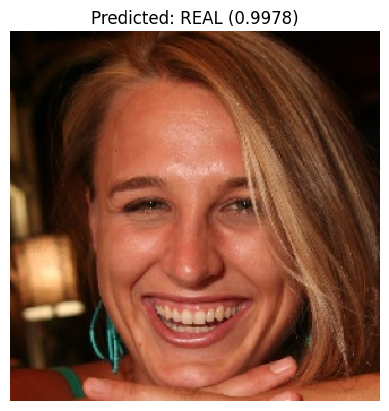


🧠 Xception Prediction: 0.9955
🧠 EfficientNetB3 Prediction: 1.0000
⚡ Ensemble Average: 0.9978
✅ Final Label: REAL


In [4]:
def ensemble_predict(img_path):
    # Prepare inputs
    x_inp, img_display = preprocess_for_xception(img_path)
    e_inp = preprocess_for_efficientnet_b3(img_path)

    # Predict probabilities
    pred_x = xception_model.predict(x_inp, verbose=0)
    if isinstance(pred_x, dict):  # happens with TFSMLayer
        pred_x = list(pred_x.values())[0]

    pred_e = efficientnet_model.predict(e_inp, verbose=0)

    # Average (soft voting)
    final_pred = (pred_x + pred_e) / 2
    prob = final_pred[0][0]
    label = "REAL" if prob > 0.5 else "FAKE"

    # === Display the image with clearer title ===
    plt.imshow(img_display)
    plt.axis("off")
    plt.title(f"Predicted: {label} (Probability: {prob:.2f})", fontsize=12, pad=10)
    plt.show()

    # === Detailed breakdown ===
    print("\n🧠 Model Probabilities:")
    print(f"   - Xception → {pred_x[0][0]:.4f}")
    print(f"   - EfficientNetB3 → {pred_e[0][0]:.4f}")
    print(f"   - Ensemble Average → {prob:.4f}")
    print(f"\n✅ Final Prediction: {label} (Probability: {prob:.2%})")


In [5]:
# Pick a test image path
test_image_path = "/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/fake/008BYSE725.jpg"

# Preprocess for Xception
x_inp, img_display = preprocess_for_xception(test_image_path)

# Now predict
pred_x = xception_model.predict(x_inp, verbose=0)
print("Xception raw output:", pred_x)


Xception raw output: {'dense_1': array([[0.21332183]], dtype=float32)}


In [6]:
e_inp = preprocess_for_efficientnet_b3(test_image_path)
pred_e = efficientnet_model.predict(e_inp, verbose=0)
print("EfficientNetB3 output:", pred_e)


EfficientNetB3 output: [[0.01009473]]


In [7]:
real_image_path = "/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/real/00001.jpg"

x_inp, _ = preprocess_for_xception(real_image_path)
pred_x = xception_model.predict(x_inp, verbose=0)
pred_x = list(pred_x.values())[0] if isinstance(pred_x, dict) else pred_x

e_inp = preprocess_for_efficientnet_b3(real_image_path)
pred_e = efficientnet_model.predict(e_inp, verbose=0)

final_pred = (pred_x + pred_e) / 2

print("Xception:", pred_x)
print("EfficientNetB3:", pred_e)
print("Ensemble:", final_pred)


Xception: [[0.99551165]]
EfficientNetB3: [[0.99999917]]
Ensemble: [[0.9977554]]


In [8]:
import os
from glob import glob

# Dataset paths
TRAIN_DIR = "/kaggle/input/rvf10k/rvf10k/train"
VALID_DIR = "/kaggle/input/rvf10k/rvf10k/valid"

# Function to get dataset info
def get_dataset_info(folder):
    real = glob(os.path.join(folder, "real/*"))
    fake = glob(os.path.join(folder, "fake/*"))
    print(f"{folder} - Real: {len(real)}, Fake: {len(fake)}, Total: {len(real)+len(fake)}")
    return real, fake

# Train set info
train_real, train_fake = get_dataset_info(TRAIN_DIR)

# Validation set info
valid_real, valid_fake = get_dataset_info(VALID_DIR)

# Combine paths and labels
train_paths = train_real + train_fake
train_labels = [0]*len(train_real) + [1]*len(train_fake)  # 0=Real, 1=Fake

valid_paths = valid_real + valid_fake
valid_labels = [0]*len(valid_real) + [1]*len(valid_fake)

print(f"\nTotal training images: {len(train_paths)}")
print(f"Total validation images: {len(valid_paths)}")


/kaggle/input/rvf10k/rvf10k/train - Real: 3500, Fake: 3500, Total: 7000
/kaggle/input/rvf10k/rvf10k/valid - Real: 1500, Fake: 1500, Total: 3000

Total training images: 7000
Total validation images: 3000


In [9]:
from tensorflow.keras.preprocessing import image
import numpy as np
import tensorflow as tf

# Optional data augmentation
meta_data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.RandomZoom(0.05),
])

# Preprocess function for Xception (meta-model)
def meta_preprocess_xception(img_path):
    img = image.load_img(img_path, target_size=(299, 299))
    img_array = image.img_to_array(img)
    img_array = tf.keras.applications.xception.preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = meta_data_augmentation(img_array)
    return img_array

# Preprocess function for EfficientNetB3 (meta-model)
def meta_preprocess_efficientnet(img_path):
    img = image.load_img(img_path, target_size=(300, 300))
    img_array = image.img_to_array(img)
    img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = meta_data_augmentation(img_array)
    return img_array


In [10]:
from tqdm import tqdm
import numpy as np

def generate_predictions_meta(image_paths, x_model, e_model):
   
    preds_x, preds_e = [], []
    for img_path in tqdm(image_paths):
        # Preprocess for Xception (meta)
        x_inp = meta_preprocess_xception(img_path)
        # Predict
        pred_x = x_model.predict(x_inp, verbose=0)
        if isinstance(pred_x, dict):  # TFSMLayer returns dict
            pred_x = list(pred_x.values())[0]
        preds_x.append(pred_x[0][0])
        
        # Preprocess for EfficientNetB3 (meta)
        e_inp = meta_preprocess_efficientnet(img_path)
        pred_e = e_model.predict(e_inp, verbose=0)
        preds_e.append(pred_e[0][0])
        
    return np.array(preds_x), np.array(preds_e)

# Generate train predictions for meta-model
print("Generating predictions for training set...")
train_preds_x, train_preds_e = generate_predictions_meta(train_paths, xception_model, efficientnet_model)

# Generate validation predictions for meta-model
print("Generating predictions for validation set...")
valid_preds_x, valid_preds_e = generate_predictions_meta(valid_paths, xception_model, efficientnet_model)


X_train = np.vstack([train_preds_x, train_preds_e]).T
X_valid = np.vstack([valid_preds_x, valid_preds_e]).T
y_train = np.array(train_labels)
y_valid = np.array(valid_labels)

print("\nFeature matrices shapes:")
print("X_train:", X_train.shape, "X_valid:", X_valid.shape)


Generating predictions for training set...


100%|██████████| 7000/7000 [26:52<00:00,  4.34it/s]


Generating predictions for validation set...


100%|██████████| 3000/3000 [11:37<00:00,  4.30it/s]


Feature matrices shapes:
X_train: (7000, 2) X_valid: (3000, 2)


In [11]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# Initialize XGBoost classifier
meta_model = xgb.XGBClassifier(
    n_estimators=500,       # max boosting rounds
    learning_rate=0.05,     # step size shrinkage
    max_depth=3,             # max tree depth
    subsample=0.8,           # row subsampling
    colsample_bytree=0.8,    # feature subsampling
    eval_metric='logloss',   # evaluation metric
    use_label_encoder=False
)

# Train the meta-model
meta_model.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    early_stopping_rounds=50,  # stop if validation doesn't improve for 50 rounds
    verbose=True               # shows log per boosting round
)

[0]	validation_0-logloss:0.65858
[1]	validation_0-logloss:0.61892
[2]	validation_0-logloss:0.59037
[3]	validation_0-logloss:0.55688
[4]	validation_0-logloss:0.53293
[5]	validation_0-logloss:0.51085
[6]	validation_0-logloss:0.48369
[7]	validation_0-logloss:0.46506
[8]	validation_0-logloss:0.44137
[9]	validation_0-logloss:0.42544
[10]	validation_0-logloss:0.41061
[11]	validation_0-logloss:0.39704
[12]	validation_0-logloss:0.37823
[13]	validation_0-logloss:0.36073
[14]	validation_0-logloss:0.34445
[15]	validation_0-logloss:0.32920
[16]	validation_0-logloss:0.31509
[17]	validation_0-logloss:0.30608
[18]	validation_0-logloss:0.29774
[19]	validation_0-logloss:0.28555
[20]	validation_0-logloss:0.27410
[21]	validation_0-logloss:0.26725
[22]	validation_0-logloss:0.26076
[23]	validation_0-logloss:0.25073
[24]	validation_0-logloss:0.24142
[25]	validation_0-logloss:0.23612
[26]	validation_0-logloss:0.22766
[27]	validation_0-logloss:0.21970
[28]	validation_0-logloss:0.21228
[29]	validation_0-loglos

/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[96]	validation_0-logloss:0.09310
[97]	validation_0-logloss:0.09307
[98]	validation_0-logloss:0.09303
[99]	validation_0-logloss:0.09263
[100]	validation_0-logloss:0.09230
[101]	validation_0-logloss:0.09198
[102]	validation_0-logloss:0.09160
[103]	validation_0-logloss:0.09157
[104]	validation_0-logloss:0.09154
[105]	validation_0-logloss:0.09111
[106]	validation_0-logloss:0.09111
[107]	validation_0-logloss:0.09076
[108]	validation_0-logloss:0.09041
[109]	validation_0-logloss:0.09041
[110]	validation_0-logloss:0.09037
[111]	validation_0-logloss:0.09035
[112]	validation_0-logloss:0.09007
[113]	validation_0-logloss:0.08981
[114]	validation_0-logloss:0.08982
[115]	validation_0-logloss:0.08983
[116]	validation_0-logloss:0.08985
[117]	validation_0-logloss:0.08988
[118]	validation_0-logloss:0.08962
[119]	validation_0-logloss:0.08938
[120]	validation_0-logloss:0.08942
[121]	validation_0-logloss:0.08941
[122]	validation_0-logloss:0.08918
[123]	validation_0-logloss:0.08922
[124]	validation_0-loglo

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [14]:
y_pred = meta_model.predict(X_valid)

In [15]:
acc = accuracy_score(y_valid, y_pred)
f1 = f1_score(y_valid, y_pred)

print(f"\nMeta-model Accuracy: {acc:.4f}")
print(f"Meta-model F1 Score: {f1:.4f}")




Meta-model Accuracy: 0.9667
Meta-model F1 Score: 0.9668


In [17]:
# Save the trained meta-model
meta_model.save_model("meta_model.json")
print("\n✅ Meta-model saved as meta_model.json")


✅ Meta-model saved as meta_model.json


In [18]:
import os
from glob import glob

test_real = glob("/kaggle/input/real-vs-fake-faces/real/*")
test_fake = glob("/kaggle/input/real-vs-fake-faces/fake/*")

X_test_paths = test_real + test_fake
y_test = [0]*len(test_real) + [1]*len(test_fake)  # 0=REAL, 1=FAKE

print(f"Total test images: {len(X_test_paths)} (Real: {len(test_real)}, Fake: {len(test_fake)})")


Total test images: 2041 (Real: 1081, Fake: 960)


In [19]:
from tqdm import tqdm
import numpy as np

def generate_meta_features_progress(image_paths):
    """
    Generate base model predictions for meta-model input with progress bar.
    Returns a feature matrix: [Xception_pred, EfficientNetB3_pred]
    """
    x_preds, e_preds = [], []
    for img_path in tqdm(image_paths, desc="Generating meta features"):
        # Preprocess using meta-model preprocessing
        x_inp = meta_preprocess_xception(img_path)
        e_inp = meta_preprocess_efficientnet(img_path)
        
        # Base model predictions
        pred_x = xception_model.predict(x_inp, verbose=0)
        if isinstance(pred_x, dict):  # TFSMLayer returns dict
            pred_x = list(pred_x.values())[0]
        pred_x = pred_x[0][0]
        
        pred_e = efficientnet_model.predict(e_inp, verbose=0)[0][0]
        
        x_preds.append(pred_x)
        e_preds.append(pred_e)
    
    X_features = np.vstack([x_preds, e_preds]).T
    print(f"\nMeta feature matrix shape: {X_features.shape}")
    return X_features

# Usage
X_test = generate_meta_features_progress(X_test_paths)


Generating meta features: 100%|██████████| 2041/2041 [08:21<00:00,  4.07it/s]


Meta feature matrix shape: (2041, 2)


In [ ]:
# Meta-model predictions

y_pred = meta_model.predict(X_test)                
y_valid = meta_model.predict_proba(X_test)[:,1]     


In [20]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
y_true = y_valid
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=["REAL", "FAKE"]))


Classification Report:

              precision    recall  f1-score   support

        REAL       0.97      0.96      0.97      1500
        FAKE       0.96      0.97      0.97      1500

    accuracy                           0.97      3000
   macro avg       0.97      0.97      0.97      3000
weighted avg       0.97      0.97      0.97      3000



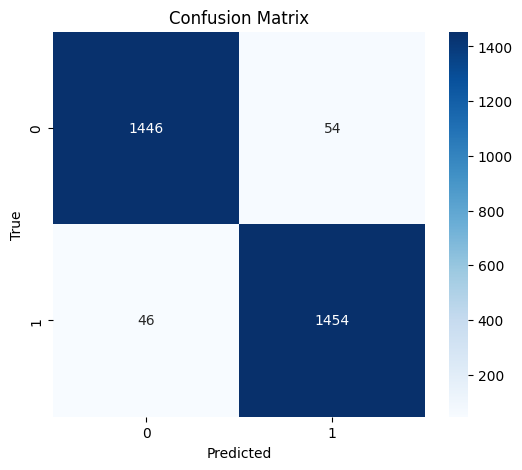

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_valid, y_pred)

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


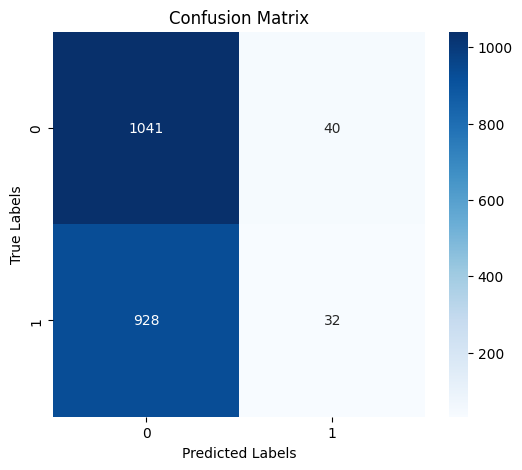


Classification Report:

              precision    recall  f1-score   support

           0       0.53      0.96      0.68      1081
           1       0.44      0.03      0.06       960

    accuracy                           0.53      2041
   macro avg       0.49      0.50      0.37      2041
weighted avg       0.49      0.53      0.39      2041



In [22]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Predict using your trained meta-model
y_p1 = meta_model.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_p1)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_p1))
